<a href="https://colab.research.google.com/github/almirarana31/datasciencefinal/blob/main/twitter_machine_learning_and_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

file_path = 'twitter_cleaned (1).csv'
twitter_data = pd.read_csv(file_path)

twitter_data['Hashtag Count'] = twitter_data['full_text'].str.count(r"#\w+").fillna(0)

twitter_data['Engagement Ratio'] = (twitter_data['favorite_count'] / twitter_data['total_engagements']).replace(
    [float('inf'), -float('inf')], 0).fillna(0)
twitter_data['Engagement Level'] = pd.cut(
    twitter_data['Engagement Ratio'],
    bins=[-float('inf'), 0.02, 0.05, float('inf')],
    labels=['Low', 'Medium', 'High']
)

vectorizer = CountVectorizer()
hashtags_vectorized = vectorizer.fit_transform(twitter_data['full_text'].fillna(""))

features = pd.DataFrame(hashtags_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
features['Log Followers'] = np.log1p(twitter_data['user_id_str'])
features['Hashtag Count'] = twitter_data['Hashtag Count']

target = twitter_data['Engagement Level']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)

scaler = StandardScaler()
numerical_cols = ['Log Followers', 'Hashtag Count']
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

        High       0.70      0.56      0.62       334
         Low       0.62      0.75      0.68       319

    accuracy                           0.65       653
   macro avg       0.66      0.65      0.65       653
weighted avg       0.66      0.65      0.65       653

Confusion Matrix:
 [[186 148]
 [ 81 238]]


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from textblob import TextBlob
from datetime import datetime

file_path = 'twitter_cleaned (1).csv'
twitter_data = pd.read_csv(file_path)

def classify_time_period(upload_time):
    hour = upload_time.hour
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

twitter_data['created_at'] = pd.to_datetime(twitter_data['created_at'], errors='coerce')
twitter_data['Time Period'] = twitter_data['created_at'].apply(lambda x: classify_time_period(x) if pd.notnull(x) else "Unknown")

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

twitter_data['Sentiment'] = twitter_data['full_text'].fillna("").apply(get_sentiment)

twitter_data['Unique Hashtags'] = twitter_data['full_text'].str.findall(r"#\w+").apply(lambda x: len(set(x)) if x else 0)

twitter_data['Likes-to-Engagements Ratio'] = (twitter_data['favorite_count'] / twitter_data['total_engagements']).replace(
    [float('inf'), -float('inf')], 0).fillna(0)
twitter_data['Engagement Level'] = pd.cut(
    twitter_data['Likes-to-Engagements Ratio'],
    bins=[-float('inf'), 0.02, 0.05, float('inf')],
    labels=['Low', 'Medium', 'High']
)

vectorizer = CountVectorizer()
hashtags_vectorized = vectorizer.fit_transform(twitter_data['full_text'].fillna(""))

features = pd.DataFrame(hashtags_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
features['Log Followers'] = np.log1p(twitter_data['user_id_str'])  # Using user_id_str as proxy for followers
features['Hashtag Count'] = twitter_data['full_text'].str.count(r"#\w+").fillna(0)
features['Unique Hashtags'] = twitter_data['Unique Hashtags']

sentiment_encoded = pd.get_dummies(twitter_data['Sentiment'], prefix='Sentiment')
time_period_encoded = pd.get_dummies(twitter_data['Time Period'], prefix='TimePeriod')
features = pd.concat([features, sentiment_encoded, time_period_encoded], axis=1)

target = twitter_data['Engagement Level']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)

label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

scaler = StandardScaler()
numerical_cols = ['Log Followers', 'Hashtag Count', 'Unique Hashtags']
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_encoded, test_size=0.2, random_state=42)

<ipython-input-17-276b37a3ef96>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  twitter_data['created_at'] = pd.to_datetime(twitter_data['created_at'], errors='coerce')


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

param_grid = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 3
}

best_xgb = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    **param_grid
)
best_xgb.fit(X_train, y_train)

y_pred_best_xgb = best_xgb.predict(X_test)
report_best_xgb = classification_report(y_test, y_pred_best_xgb, target_names=label_encoder.classes_)
conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

print("\nClassification Report (Best XGBoost):\n", report_best_xgb)
print("\nConfusion Matrix (Best XGBoost):\n", conf_matrix_best_xgb)



Classification Report (Best XGBoost):
               precision    recall  f1-score   support

        High       0.67      0.61      0.64       334
         Low       0.63      0.69      0.66       319

    accuracy                           0.65       653
   macro avg       0.65      0.65      0.65       653
weighted avg       0.65      0.65      0.65       653


Confusion Matrix (Best XGBoost):
 [[205 129]
 [ 99 220]]


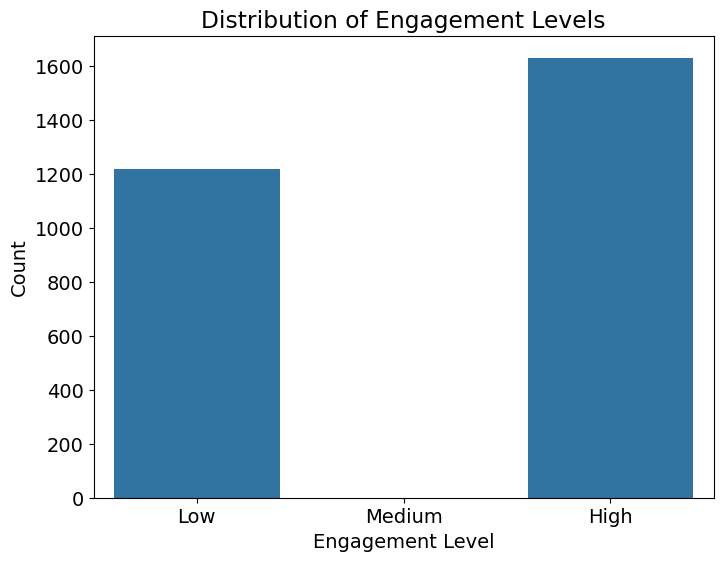

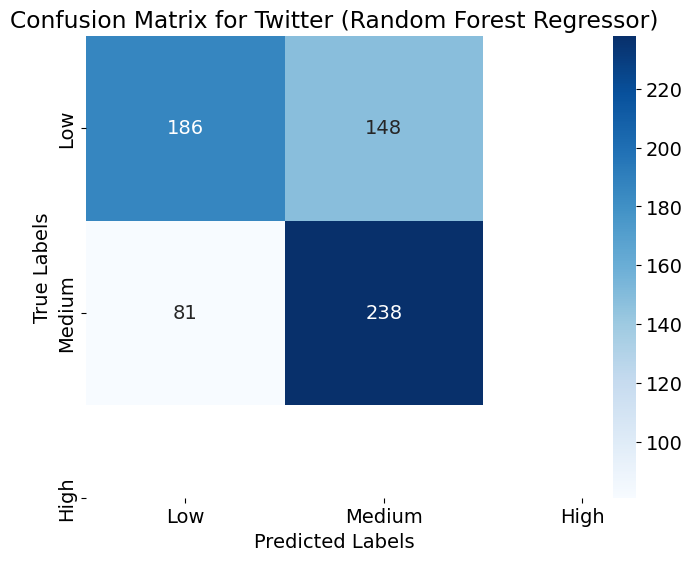

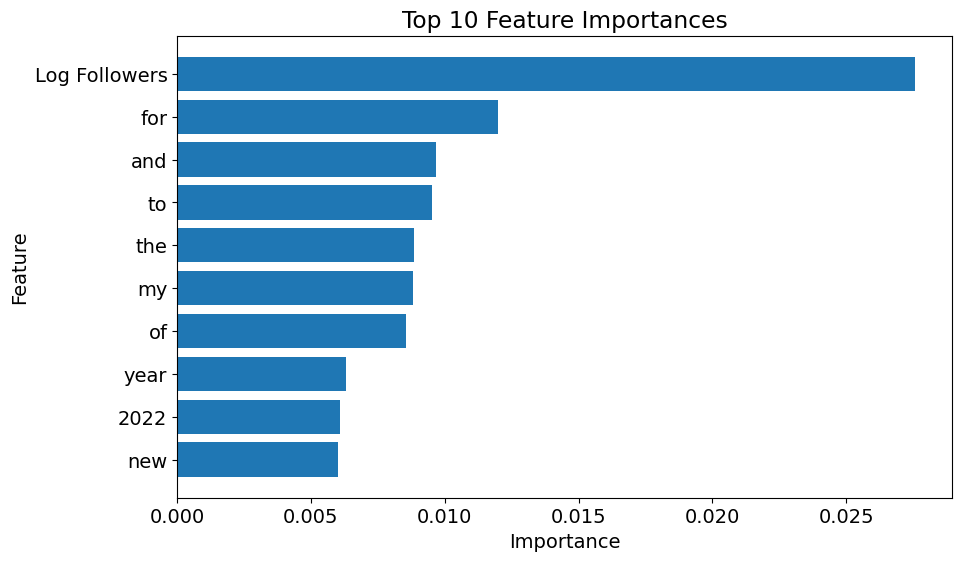

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance

plt.figure(figsize=(8, 6))
sns.countplot(data=twitter_data, x='Engagement Level', order=['Low', 'Medium', 'High'])
plt.title('Distribution of Engagement Levels')
plt.xlabel('Engagement Level')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix for Twitter (Random Forest Regressor)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

feature_importances = rf_classifier.feature_importances_
feature_names = features.columns

sorted_idx = np.argsort(feature_importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


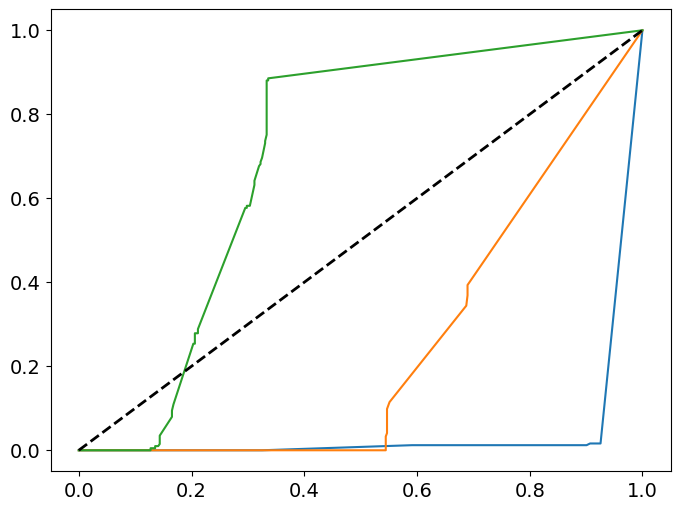

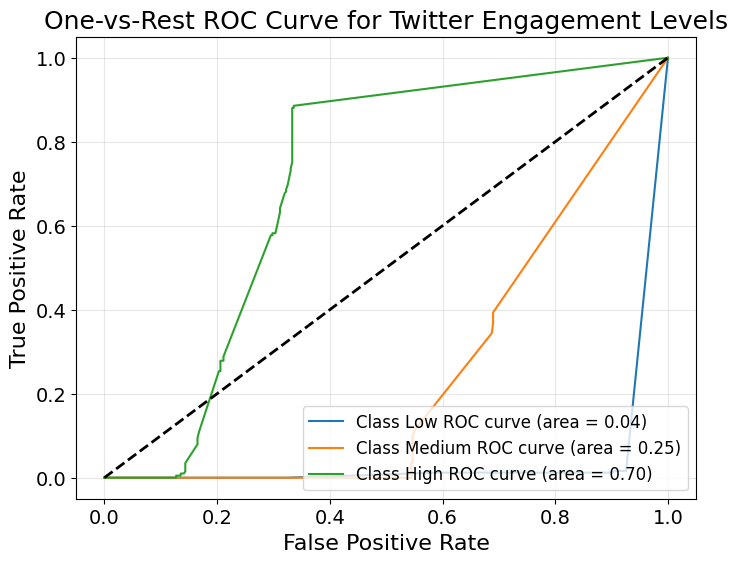

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

file_path = 'twitter_cleaned (1).csv'
twitter_data = pd.read_csv(file_path)

twitter_data['Hashtag Count'] = twitter_data['full_text'].str.count(r"#\w+").fillna(0)
twitter_data['Engagement Ratio'] = (twitter_data['favorite_count'] / twitter_data['total_engagements']).replace(
    [float('inf'), -float('inf')], 0).fillna(0)
twitter_data['Engagement Level'] = pd.cut(
    twitter_data['Engagement Ratio'],
    bins=[-float('inf'), 0.25, 0.75, float('inf')],
    labels=['Low', 'Medium', 'High']
)

features = twitter_data[['Hashtag Count', 'favorite_count', 'retweet_count']].fillna(0)
target = twitter_data['Engagement Level']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_test_binarized = label_binarize(y_test, classes=['Low', 'Medium', 'High'])
y_pred_proba = rf_classifier.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

classes = ['Low', 'Medium', 'High']
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

plt.figure(figsize=(8, 6))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} ROC curve (area = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 6))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} ROC curve (area = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("One-vs-Rest ROC Curve for Twitter Engagement Levels", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

   conversation_id_str                      created_at  favorite_count  \
0  1774586599688605879  Sun Mar 31 23:56:30 +0000 2024               0   
1  1774586580100952423  Sun Mar 31 23:56:25 +0000 2024               2   
2  1774586564959424732  Sun Mar 31 23:56:21 +0000 2024               3   
3  1774359400020398081  Sun Mar 31 23:56:12 +0000 2024              13   
4  1774497205316915587  Sun Mar 31 23:56:03 +0000 2024               5   

                                           full_text               id_str  \
0  @indicthim you should get off social media and...  1774586599688605879   
1  Describe Your Mental Health with your third Em...  1774586580100952423   
2  Current Mental health status.... Coneheads. mo...  1774586564959424732   
3  @Gelvetication @Tamias1000 @happinasu @LumLotu...  1774586526820704592   
4  @ask_aubry It sounds like he was asked to do s...  1774586487092166784   

  image_url in_reply_to_screen_name lang                     location  \
0       NaN        

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:31:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


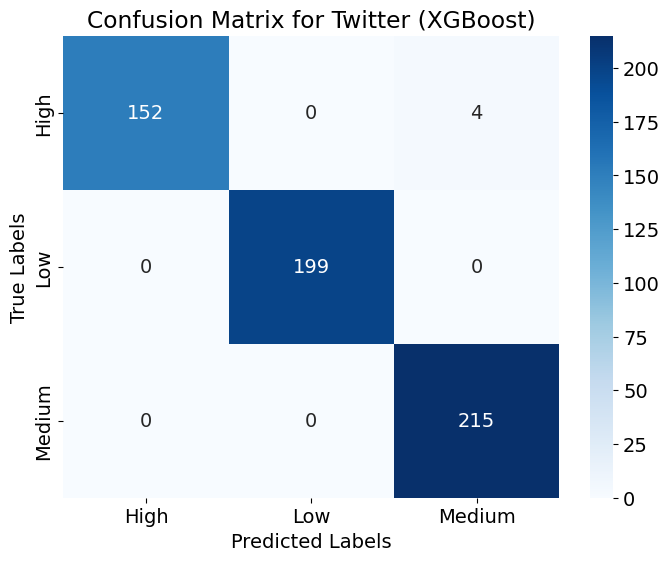

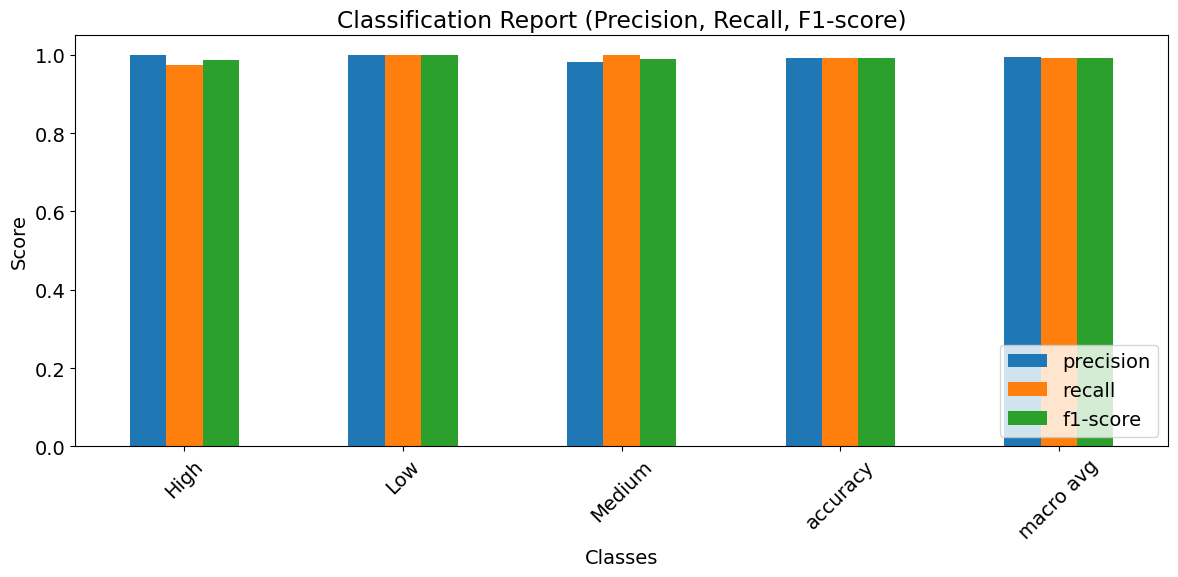

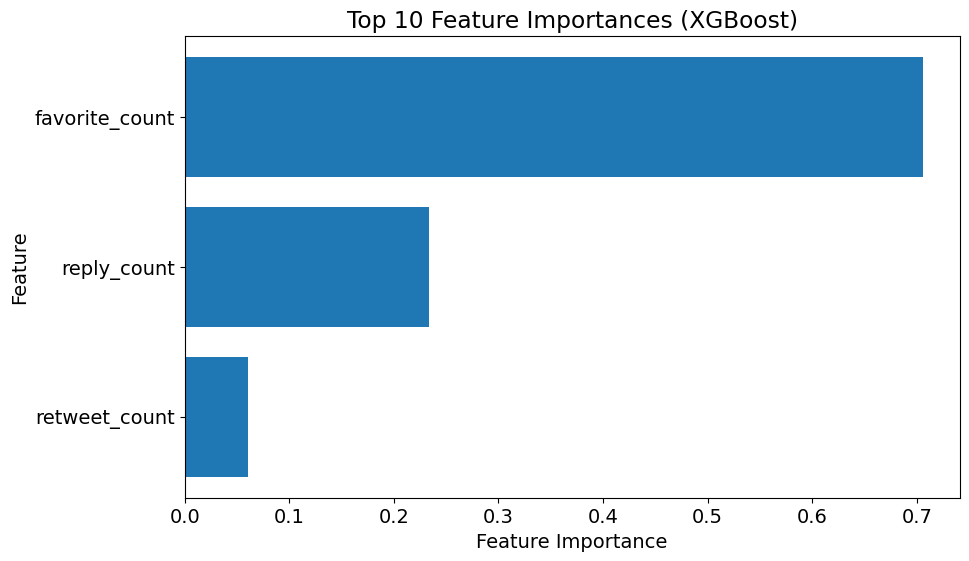

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

file_path_twitter_cleaned = 'twitter_cleaned (1).csv'
data_twitter_cleaned = pd.read_csv(file_path_twitter_cleaned)

print(data_twitter_cleaned.head())
print(data_twitter_cleaned.info())


engagement_rate = data_twitter_cleaned['engagement_rate']
low_threshold = np.percentile(engagement_rate, 33)
high_threshold = np.percentile(engagement_rate, 66)

data_twitter_cleaned['Engagement Category'] = pd.cut(
    engagement_rate,
    bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
    labels=['Low', 'Medium', 'High']
)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_twitter_cleaned['Engagement Category'])

features_twitter = ['favorite_count', 'reply_count', 'retweet_count']
X_twitter = data_twitter_cleaned[features_twitter]


X_train, X_test, y_train, y_test = train_test_split(X_twitter, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

best_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=10
)

best_xgb.fit(X_train, y_train)

y_pred_best_xgb = np.argmax(best_xgb.predict_proba(X_test), axis=1)

conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Twitter (XGBoost)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

classification_df = pd.DataFrame(classification_report(y_test, y_pred_best_xgb,
                                                        target_names=label_encoder.classes_, output_dict=True)).T
classification_df = classification_df.iloc[:-1, :3]
classification_df.plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report (Precision, Recall, F1-score)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

feature_importances = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features_twitter[i] for i in sorted_idx])
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()



In [22]:
tiktok_data = pd.read_csv('final_tiktok_hasviews.csv')
twitter_data = pd.read_csv('twitter_cleaned (1).csv')

<Figure size 1000x600 with 0 Axes>

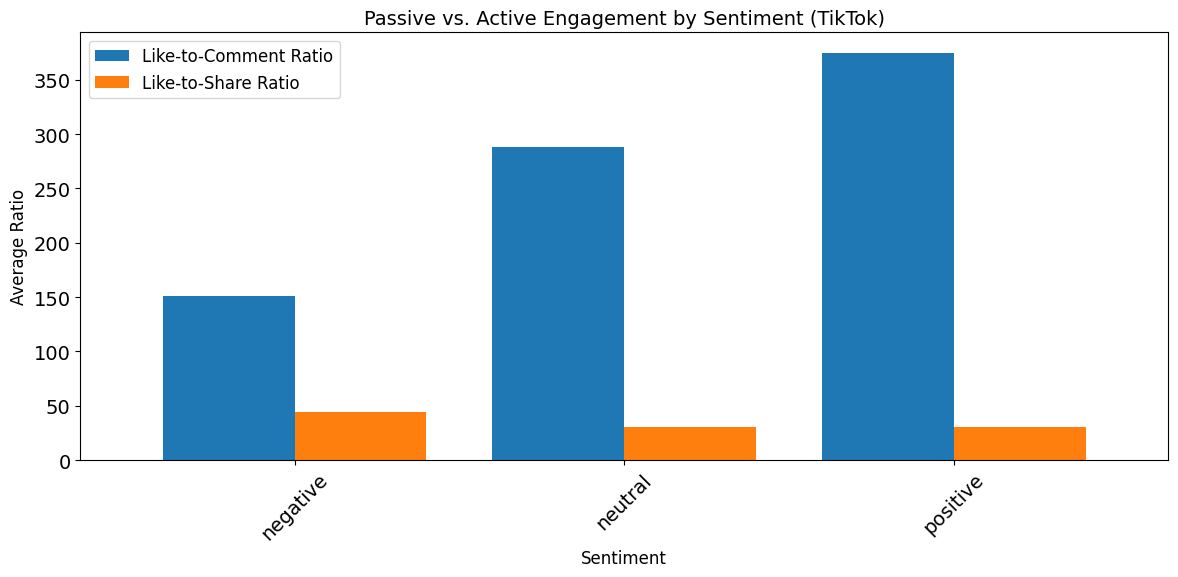

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

tiktok_data['Like-to-Comment Ratio'] = tiktok_data['Likes'] / tiktok_data['Comments'].replace(0, 1)
tiktok_data['Like-to-Share Ratio'] = tiktok_data['Likes'] / tiktok_data['Shares'].replace(0, 1)

engagement_by_sentiment = tiktok_data.groupby('Sentiment').agg({
    'Like-to-Comment Ratio': 'mean',
    'Like-to-Share Ratio': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
engagement_by_sentiment.set_index('Sentiment').plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Passive vs. Active Engagement by Sentiment (TikTok)', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Like-to-Comment Ratio', 'Like-to-Share Ratio'], fontsize=12)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

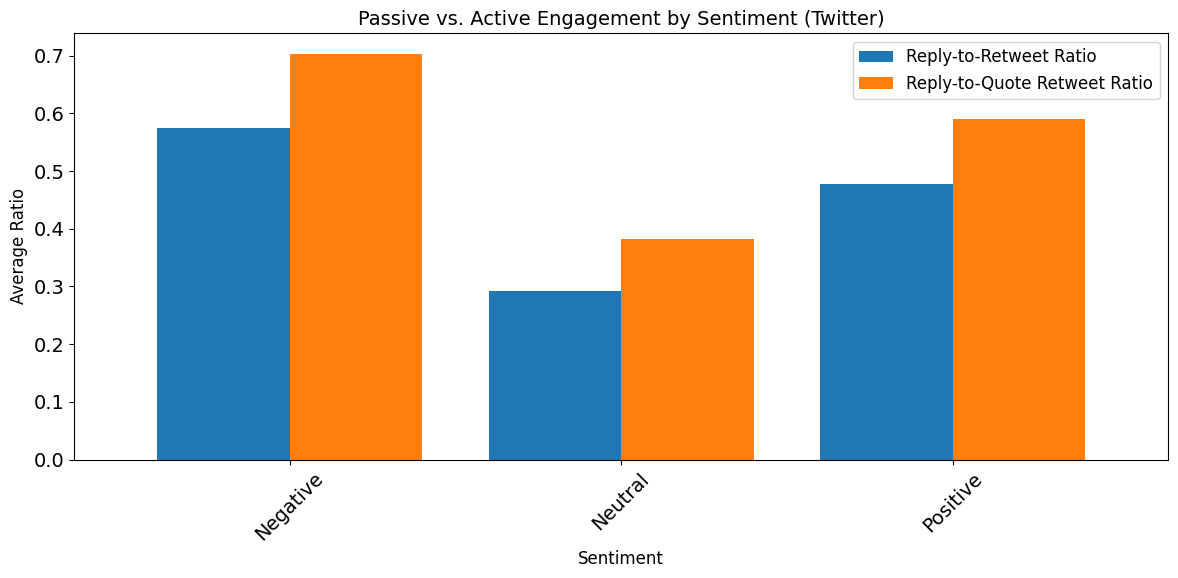

In [24]:
import matplotlib.pyplot as plt

twitter_data['Reply-to-Retweet Ratio'] = twitter_data['reply_count'] / twitter_data['retweet_count'].replace(0, 1)
twitter_data['Reply-to-Quote Retweet Ratio'] = twitter_data['reply_count'] / twitter_data['quote_count'].replace(0, 1)

engagement_by_sentiment = twitter_data.groupby('sentiment').agg({
    'Reply-to-Retweet Ratio': 'mean',
    'Reply-to-Quote Retweet Ratio': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
engagement_by_sentiment.set_index('sentiment').plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Passive vs. Active Engagement by Sentiment (Twitter)', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Reply-to-Retweet Ratio', 'Reply-to-Quote Retweet Ratio'], fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

Category Distribution:
Engagement Category
Medium    1075
Low        992
High       781
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


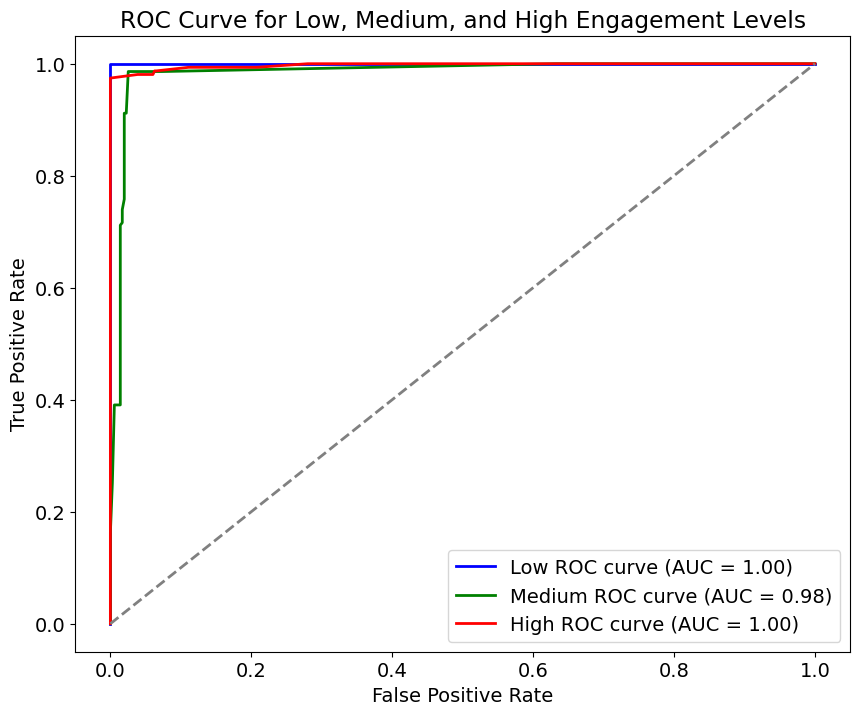

In [28]:
engagement_rate = data_twitter_cleaned['engagement_rate']
low_threshold = np.percentile(engagement_rate, 33)
high_threshold = np.percentile(engagement_rate, 66)

data_twitter_cleaned['Engagement Category'] = pd.cut(
    engagement_rate,
    bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
    labels=['Low', 'Medium', 'High']
)

print("Category Distribution:")
print(data_twitter_cleaned['Engagement Category'].value_counts())

features_twitter = ['favorite_count', 'reply_count', 'retweet_count']
X_twitter = data_twitter_cleaned[features_twitter]
y_twitter = data_twitter_cleaned['Engagement Category']

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
categories = ['Low', 'Medium', 'High']
auc_scores = {}

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X_twitter, y_twitter):
    X_train_twitter, X_test_twitter = X_twitter.iloc[train_index], X_twitter.iloc[test_index]
    y_train_twitter, y_test_twitter = y_twitter.iloc[train_index], y_twitter.iloc[test_index]

    for i, category in enumerate(categories):
        y_train_binary = (y_train_twitter == category).astype(int)
        y_test_binary = (y_test_twitter == category).astype(int)

        xgb_model_twitter = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=30,
            max_depth=2,
            reg_alpha=1,
            reg_lambda=10
        )
        xgb_model_twitter.fit(X_train_twitter, y_train_binary)

        y_probs_twitter = xgb_model_twitter.predict_proba(X_test_twitter)[:, 1]

        fpr_twitter, tpr_twitter, thresholds_twitter = roc_curve(y_test_binary, y_probs_twitter)
        roc_auc_twitter = auc(fpr_twitter, tpr_twitter)
        auc_scores[category] = roc_auc_twitter

        plt.plot(fpr_twitter, tpr_twitter, color=colors[i], lw=2,
                 label=f'{category} ROC curve (AUC = {roc_auc_twitter:.2f})')

# Plot reference line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Low, Medium, and High Engagement Levels')
plt.legend(loc='lower right')
plt.show()